In [1]:
import h5py
import tsnecuda
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sklearn.decomposition
import sklearn.cluster
import scipy.spatial
import seaborn as sns

In [30]:
files = np.asarray(list(map(str.strip, open("../lists/glint360.txt").readlines())))
subset = np.random.RandomState(2463426724).random(len(files)) < P
subset_files = files[subset]

In [2]:
subset_embeddings = h5py.File("webface_r50_pfc.onnx.0.02-embeddings.h5", "r")
prefacen = subset_embeddings["prefacen"][()]

In [28]:
P = 0.02

In [75]:
subset = np.random.RandomState(2463426724).random(len(files)) < P

In [76]:
np.sum(subset)

342012

In [6]:
np.save(f"subset-{P}.npy", embeddings["prefacen"][()][subset])

In [6]:
subset_embeddings = np.load(f"subset-{P}.npy")
subset_embeddings = (subset_embeddings-subset_embeddings.mean(0))/subset_embeddings.std(0)

In [34]:
tsne = tsnecuda.TSNE(
    num_neighbors=1000,
    perplexity=200, n_iter=4000, learning_rate=2000
).fit_transform(prefacen)

In [154]:
np.save(f"tsne-latest.npy", tsne)

In [36]:
ntsne = (tsne - tsne.mean(0)) / tsne.std(0)

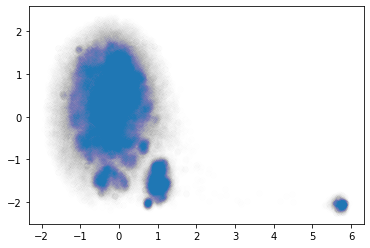

In [37]:
plt.scatter(*ntsne[::5].T, alpha=0.002)

In [38]:
class KNNDBSCAN(sklearn.cluster.DBSCAN):
    """DBSCAN worked well when I sample down points. But gives no prediction.
    So I train KNN on top of cluster labels
    """
    def __init__(self, *args, subset=1, knn_params=None, random_seed=42, **kwargs, ):
        super().__init__(*args, **kwargs)
        knn_params = knn_params or dict()
        self.knn = sklearn.neighbors.KNeighborsClassifier(
            n_jobs=kwargs.pop("n_jobs", None),
            **knn_params
        )
        self.subset_ = subset
        self.rng = np.random.RandomState(random_seed)
    
    def subset(self, X, y=None):
        train_idx = np.arange(len(X))
        self.rng.shuffle(train_idx)
        train_idx = train_idx[:int(len(X) * self.subset_)]
        if y is None:
            return X[train_idx]
        else:
            return X[train_idx], y[train_idx]

    def fit(self, X):
        train_X = self.subset(X)
        super().fit(train_X)
        train_labels = self.labels_
        train_kidx = np.where(train_labels >= 0)
        self.knn.fit(train_X[train_kidx], train_labels[train_kidx])
        del self.labels_
        return self
    
    def predict(self, X):
        return self.knn.predict(X)

    def fit_predict(self, X):
        return self.fit(X).predict(X)

In [39]:
kdtree = scipy.spatial.KDTree(ntsne)

In [40]:
dists, points = kdtree.query(ntsne, k=50)

In [107]:
def display_labels(X, labels, slc=slice(None, None, None), alpha=0.1, ax=plt):
    cmap = plt.get_cmap("tab20")
    colors = []
    for c in np.unique(labels):
        col = cmap(c/max(labels))
        colors.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col))
        ax.scatter(*X[slc][labels[slc] == c].T, color=col, alpha=alpha)
    plt.legend(colors, np.unique(labels), bbox_to_anchor=(1.05, 1))

In [42]:
dists.shape

(342012, 50)

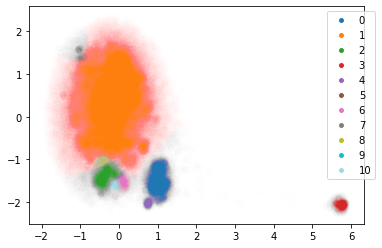

In [74]:
y = KNNDBSCAN(min_samples=120, subset=0.5, eps=0.05, knn_params=dict(n_neighbors=5)).fit_predict(ntsne)
display_labels(ntsne, y, slc=slice(None, None, 5), alpha=0.002)

In [54]:
np.unique(y, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 33260, 275486,  16709,   5821,   2354,    895,   3277,   1917,
          1126,    354,    813]))

In [56]:
def display_label(ax, labels, select: int, slc=slice(None, None, 5), alpha=0.005):
    cmap = plt.get_cmap("tab20")
    colors = []
    for c in np.unique(labels):
        if c == select:
            a = 1
        else:
            a = alpha
        col = cmap(c/max(labels))
        ax.scatter(*tsne[slc][labels[slc] == c].T, color=col, alpha=a)
        ax.set_title(f"class: {select}")

In [57]:
def display_clusters(labels, slc=slice(None, None, 5), alpha=0.005):
    R = len(np.unique(labels))
    C = 17
    S = 2
    fig, axes = plt.subplots(R, C, figsize=(S * C, S * R))
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    for i, c in enumerate(np.unique(labels)):
        display_label(axes[i, 0], labels, c, slc=slc, alpha=alpha)
        img_idx = (labels == c).nonzero()[0]
        np.random.shuffle(img_idx)
        for j, s in enumerate(img_idx[:C-1]):
            img = cv2.imread("../data/" + subset_files[s])[..., ::-1]
            axes[i, j+1].imshow(img)

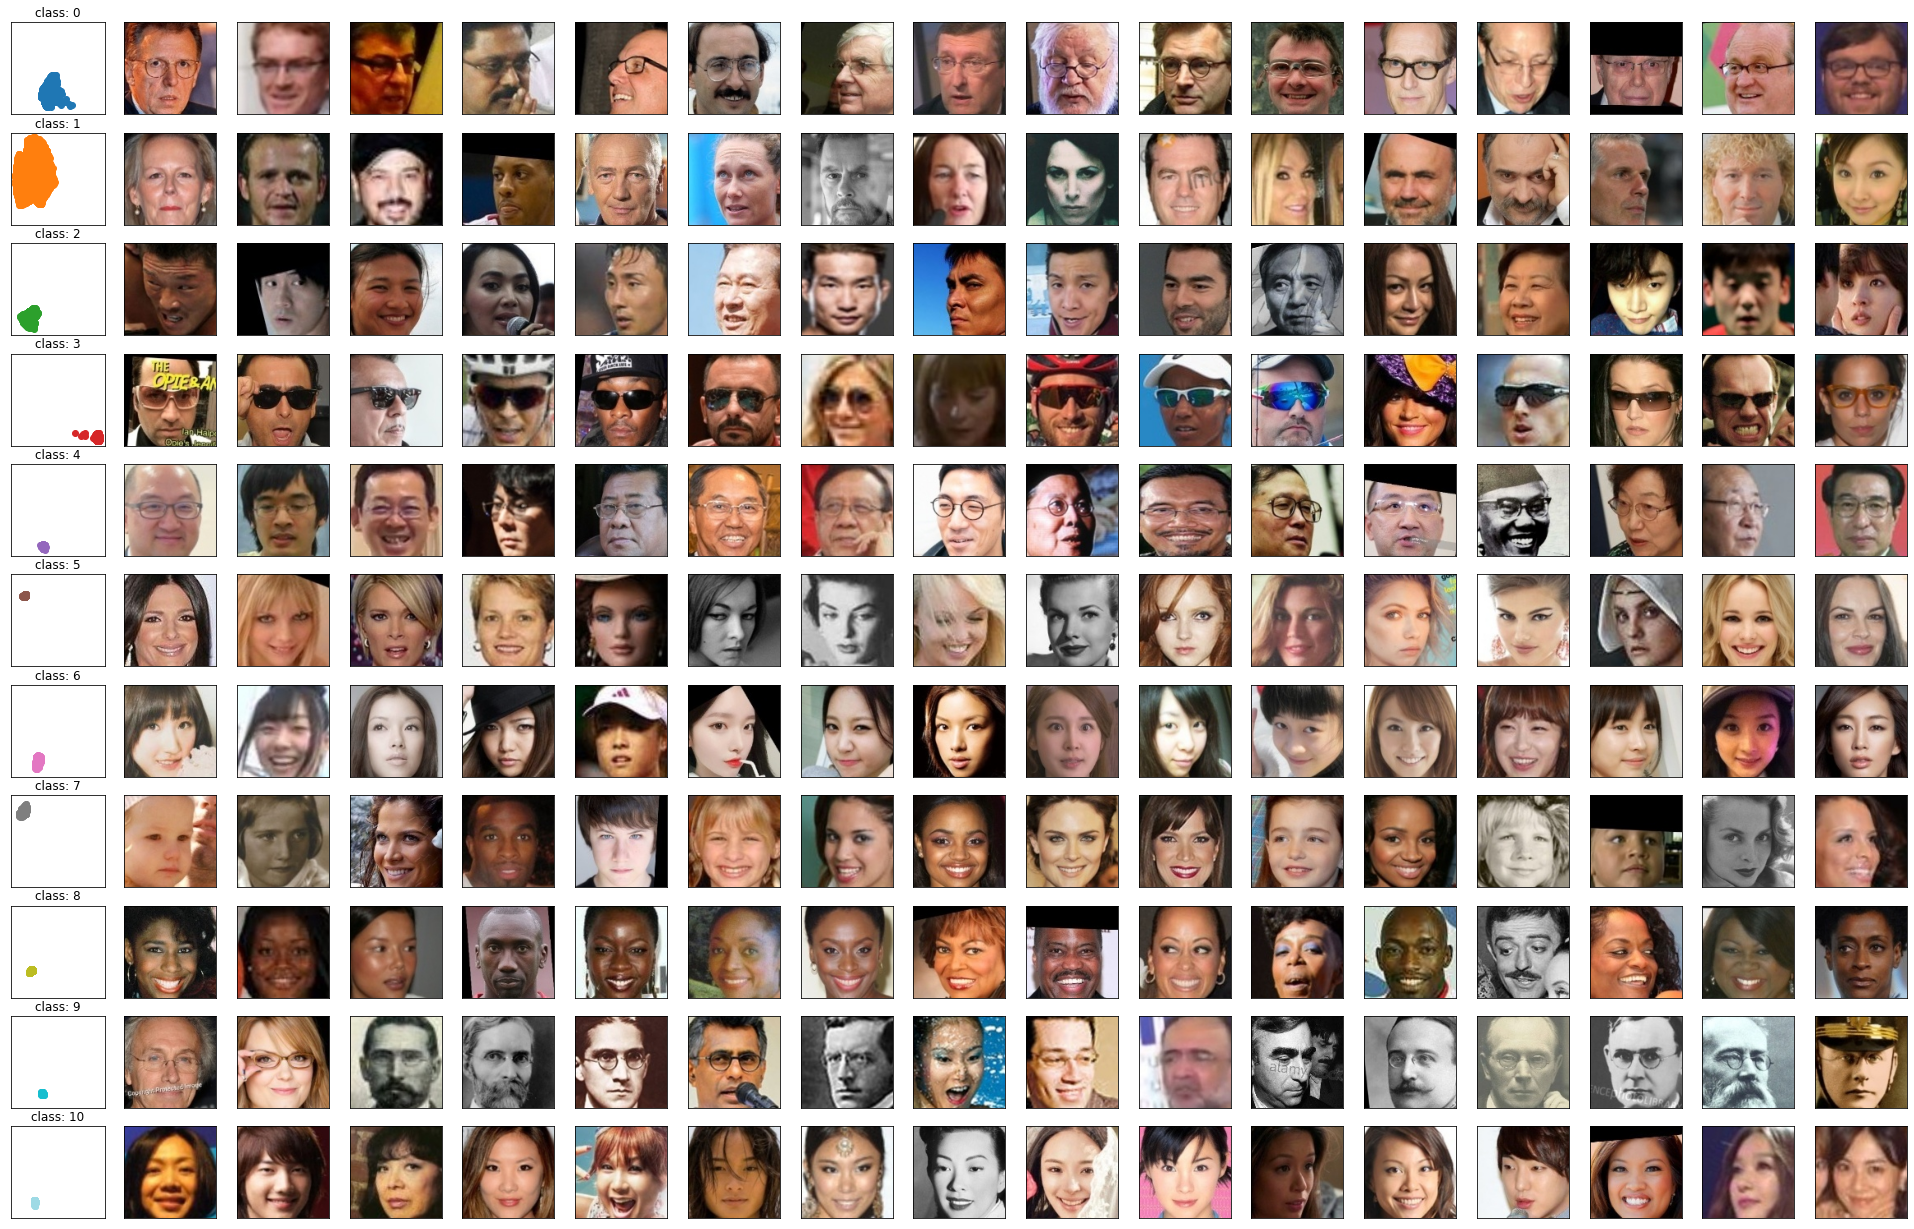

In [61]:
display_clusters(y, alpha=0.0011)

In [99]:
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics

In [89]:
cluster_model = LogisticRegressionCV(n_jobs=-1, max_iter=1000)

In [ ]:
cluster_model.fit(prefacen, y)

In [98]:
score = cluster_model.predict_proba(prefacen)

In [95]:
print(score)

0.9623083400582436


     |████████████████████████████████| 263 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.3 MB 5.7 MB/s eta 0:00:01
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)
Note: you may need to restart the kernel to use updated packages.


<BarContainer object of 11 artists>

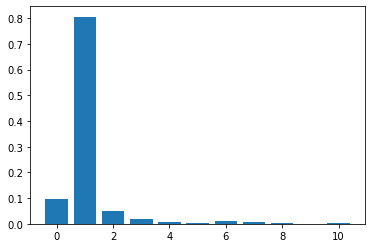

In [97]:
clust, counts = np.unique(y, return_counts=True)
fractions = counts / len(y)
plt.bar(clust, fractions)

In [101]:
sklearn.metrics.roc_auc_score(y, score, multi_class="ovo")

0.9773333938407892

In [103]:
sklearn.metrics.roc_auc_score(y, score, multi_class="ovr")

0.9830474800256117

In [105]:
sklearn.metrics.roc_auc_score(y, score, multi_class="ovo", average="weighted")

0.9741756234540639

In [106]:
sklearn.metrics.roc_auc_score(y, score, multi_class="ovr", average="weighted")

0.9830268367074794

Text(0.5, 1.0, 'Predictive labeling')

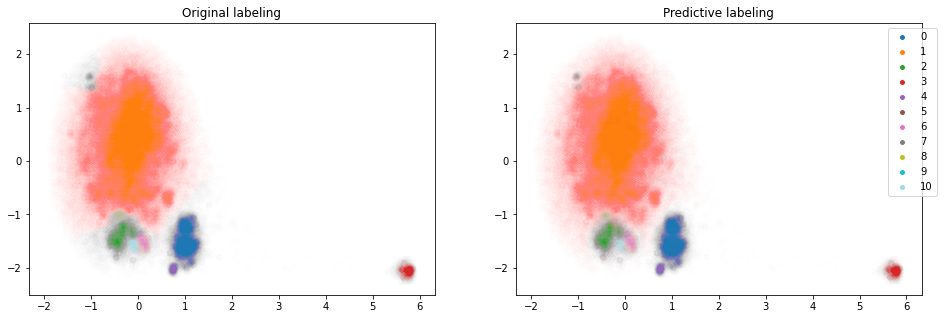

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
display_labels(ntsne, y, slc=slice(None, None, 5), alpha=0.002, ax=ax[0])
display_labels(ntsne, np.argmax(score, -1), slc=slice(None, None, 5), alpha=0.002, ax=ax[1])
ax[0].set_title("Original labeling")
ax[1].set_title("Predictive labeling")

In [138]:
import skl2onnx

In [139]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 512]))]
options = {id(cluster_model): {'raw_scores': True}}
onx = convert_sklearn(cluster_model, initial_types=initial_type, options=options)
with open("cluster_model.webface_r50_pfc.680.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [149]:
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("cluster_model.webface_r50_pfc.680.onnx")
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: prefacen[:1].astype(numpy.float32)})

In [150]:
pred_onx

[array([1], dtype=int64),
 [{0: -0.3750481605529785,
   1: 10.361465454101562,
   2: 2.2941184043884277,
   3: -2.7441513538360596,
   4: -3.972494602203369,
   5: -1.4579178094863892,
   6: 0.22086822986602783,
   7: 2.3510313034057617,
   8: -0.48730480670928955,
   9: -3.387599229812622,
   10: -2.8029682636260986}]]